# Part 3 ‐ Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

## Import

In [167]:
import pandas as pd
import numpy as np
import seaborn as sns
from phik.phik import phik_matrix
from phik.report import plot_correlation_matrix
from ydata_profiling import ProfileReport
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score

## EDA
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [137]:
df = pd.read_json('ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [139]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [140]:
df['city'].value_counts(dropna = False)

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [141]:
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].median())
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].median())
df['phone'] = df['phone'].fillna('Other/None')

In [142]:
df['phone'].value_counts(dropna = False)

iPhone        34582
Android       15022
Other/None      396
Name: phone, dtype: int64

In [143]:
df['last_trip_date'].sort_values(ascending=False)

4486    2014-07-01
43047   2014-07-01
24059   2014-07-01
40290   2014-07-01
28689   2014-07-01
           ...    
23907   2014-01-01
47804   2014-01-01
11578   2014-01-01
11573   2014-01-01
15359   2014-01-01
Name: last_trip_date, Length: 50000, dtype: datetime64[ns]

In [144]:
df['last_trip_30_days']= df['last_trip_date'] >= pd.to_datetime('2014-06-01')

In [145]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,last_trip_30_days
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


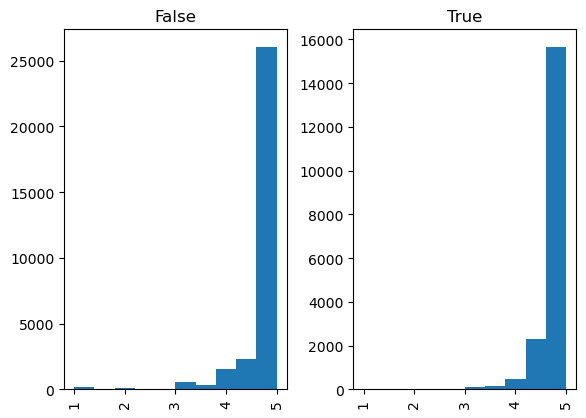

In [146]:
df.hist('avg_rating_by_driver', by= 'last_trip_30_days');

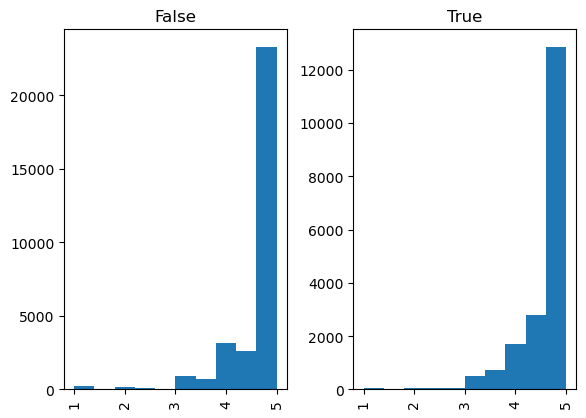

In [147]:
df.hist('avg_rating_of_driver', by= 'last_trip_30_days');

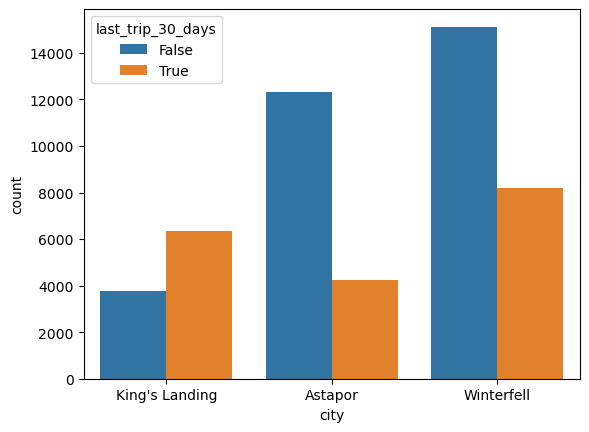

In [148]:
sns.countplot(data=df, x='city', hue='last_trip_30_days');

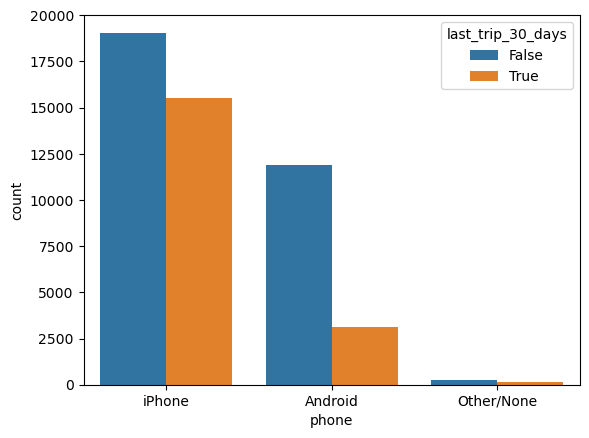

In [149]:
sns.countplot(data=df, x='phone', hue='last_trip_30_days');

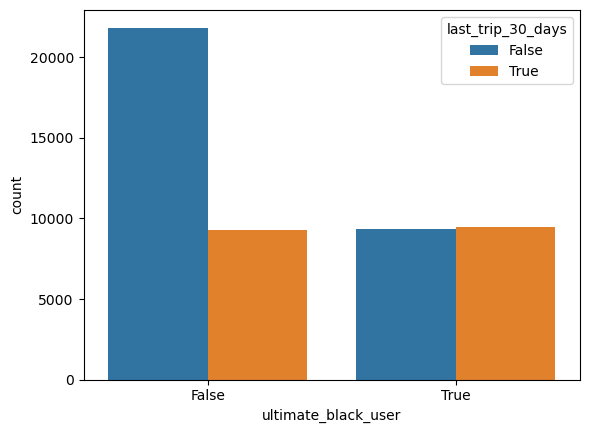

In [150]:
sns.countplot(data=df, x='ultimate_black_user', hue='last_trip_30_days');

In [151]:
ProfileReport(df, title='Dataset Report',
              progress_bar=False,
              interactions=None,
              explorative=True, dark_mode=True,
              notebook={'iframe':{'height': '600px'}},
              missing_diagrams={'heatmap': False, 'dendrogram': False}).to_notebook_iframe()

In [152]:
retained = df[df['last_trip_30_days'] == True].count().values[0]/len(df)

print(f'The percentage of people retained is {retained*100:.1f}%.')

The percentage of people retained is 37.6%.


# Model
Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

First we need to convert some of the columns from strings or datetimes to a form we can use in the machine learning algorithm.

In [153]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,last_trip_30_days
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


In [154]:
city_dict = {"King's Landing": 1, 'Astapor': 2, 'Winterfell': 3}
phone_dict = {'iPhone': 1, 'Android': 2, 'Other/None': 3}
df['signup_date'] = (pd.to_datetime('2014-06-01') - df['signup_date']).dt.days
df.replace({'city':city_dict,'phone':phone_dict}, inplace=True)

In [157]:
X = df.drop(['last_trip_30_days','last_trip_date'], axis=1)
y = df['last_trip_30_days']

In [171]:
import lightgbm as lgb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1004)
d_train=lgb.Dataset(X_train, label=y_train)

params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt'
params['objective']='binary' 
params['max_depth']=7
params['num_class']=1
params['verbose']=-1

clf=lgb.train(params,d_train,1000)

y_pred=clf.predict(X_test)

In [172]:
y_pred=y_pred.round(0)
y_pred=y_pred.astype(int)

In [173]:
roc_auc_score(y_pred,y_test)

0.7826003620180779